# 1 Aufgabestellung: Prozentuale Entwicklung der Zahlfälle (EGH) in Berlin

**Interpretation der Aufgabenstellung:**
- Es muss die prozentuelle Entwicklung der Zahlfälle (Zahlfälle = Produktmenge) explizit für die Produktnummer 80992 mit der Bezeichnung "EGH-SGB IX Leistungsgew." und Produktnummer 79376 "EGH-Soz Fallmanagement" über die letzten drei Jahre berechnet und dargestellt werden.

- Die prozentuale Entwicklung wird als **geometrisches Mittel der jährlichen Wachstumsraten** (äquivalent zur **CAGR**) umgesetzt und anschließend in Prozent dargestellt. CAGR eignet sich für die Darstellung von	Wachstumsraten bzw. wenn ein Trendwachstum statt Jahresrauschen zu zeigen ist

- Die prozentuale Entwicklung wird soll sowohl pro Bezirk als auch als entsprechend durchschnittliches Gesamtberliner Ergebnis grafisch erfolgen, nämlich „Ist Bezirk X stärker/schwächer gewachsen als Berlin insgesamt?“


**Datensätze:**
- Es wurden insgesamt 8 Jahre, ein Jahr pro Datensatz, zur Verfügung gestellt, zwischen den Jahren 2018-2025. 

**Erste Annahmen:**
- Daten entsprechen keiner Zeitreihe, nut kumulative Werte enthaltend.„Durchschnittliche monatliche Anzahl“ wird aus kumulierten Jahreswerten als *Jahreswert/12* berechnet.
- Die Zahlfälle bezieht sich auf die Spalte "Produkt-menge".
- Die Datei *"2503.."* enthält kumulierte Werte bis März 2025.

**Entwicklungsumgebung:**
- IDE: Jupyter Notebook in Visual Studio Code
- Programmierungsprache: Python 3.12.4, inkl. gänginer Bibliotheken der Datenanalyse in Virtual Enviroment (.venv)
- Styling: PEP Codierstandards

# 2 Lösungsvorschläge

1. Berechnung der Kennzahl bzw. des geometrischen Mittels (CAGR) auf die Zahlfälle pro Bezirk. </br>
   - Feste letzten drei Monate: 2018-2025
   - Rolling Fenster: Trend über 3 Jahre, um Jahresschwankungen zu glätten.

2. Berechnung der Kennzahl bzw. des geometrischen Mittels auf durchschnittliche Gesamtberliner Ergebnis

3. Visualisierung der Ergebnisse
   - Sortiertes Balkendiagramm: Kennzahl 2022–2024 je Bezirk + Referenzlinie (Berlin)
   - Small multiples / Linien: Kennzahl-Zeitreihe pro Bezirk (2019–2024 Fenster) oder Heatmap (Bezirke × Stichtage)
   - Delta-Plot: Bezirk minus Berlin (Über-/Unterentwicklung)


# 3 Vorgehensweise (nur Struktur)

1. Dateien einlesen
   - In pandas Dataframe.</br>
   - Tabellenübersicht.

2. Exploratory Data Analysis (EDA), data profiling
   - Datenaufbereitung. </br>
   - Metadaten: Spalten, Datentypen, Keys, verdoppelte Werte, fehlende Werte.</br>
   - Verteilungen, Saisonalität, Ausreißer, Bezirksvergleiche.</br>
   - Erste Erkennungen und Annahmen werden getroffen.

3. Datenqualität
   - Befunde zur Qualität der Datensätze.

4. Kennzahl-Berechnung
   - siehe Punkt 2. </br>
   - Matematische Berechnung der Kennzahl, CAGR/Geometrisches Mittel über 3 Jahre auf Basis der Ø-Monatswerte.</br>

5. Forecast 2025
   - siehe Punkt 2. </br>
   - Dieser Punkt besteht aus: Train/Validation, Modellaufbau, Prognose, Plot, Export

# 4 Coding

## 4.1 Import Bibliotheken and Setup

In [1]:
# pip install xlrd
# pip install pip install openpyxl

In [2]:
import os, re, math
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 50)

DATA_DIR = "data"
FILES = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith(".xlsx")])
FILES

['1812_PVB_lang - Kopie.xlsx',
 '1912_PVB_lang - Kopie.xlsx',
 '2012_PVB_lang - Kopie.xlsx',
 '2112_PVB_lang - Kopie.xlsx',
 '2212_PVB_lang - Kopie.xlsx',
 '2312_PVB_lang - Kopie.xlsx',
 '2412_PVB_lang - Kopie.xlsx',
 '2503_PVB_lang - Kopie.xlsx']

## 4.2 Dateien Einlesen

Es werden alle Dateien zusammengeführt, und nur für die Aufgabe relevanten Spalten gelesen.

In [4]:
def extract_year_month_from_filename(filename: str):
    # Erwartet z.B. '2212_...' -> (2022, 12) oder '2503_...' -> (2025, 3)
    m = re.match(r"(\d{2})(\d{2})_", filename)
    if not m:
        return None, None
    yy, mm = int(m.group(1)), int(m.group(2))
    return 2000 + yy, mm

def parse_pvb_minimal(path: str, ncols: int = 25) -> pd.DataFrame:
    # Bericht_lang hat eine feste Tabellenkopf-Zeile (i.d.R. Zeile 8, 0-index=7)
    raw = pd.read_excel(path, sheet_name="Bericht_lang", header=None, engine='openpyxl', usecols=list(range(ncols)))
    header = raw.iloc[7].tolist()
    df = raw.iloc[8:].copy()
    df.columns = header

    df = df.dropna(axis=1, how="all").dropna(axis=0, how="all")

    def clean_col(c):
        if c is None or (isinstance(c, float) and np.isnan(c)):
            return None
        c = str(c).replace("\n", " ")
        c = re.sub(r"\s+", " ", c).strip()
        return c

    df.columns = [clean_col(c) for c in df.columns]
    df = df.loc[:, [c for c in df.columns if c]]
    return df

def load_product(filename: str, product_num: int = 80992) -> pd.DataFrame:
    year, month_end = extract_year_month_from_filename(filename)
    path = os.path.join(DATA_DIR, filename)
    df = parse_pvb_minimal(path, ncols=25)

    df = df.rename(columns={
        "Produkt- nummer": "Produkt_nummer",
        "Produkt- menge": "Produkt_menge",
        "Produkt- bezeichnung": "Produkt_bezeichnung",
    })

    needed = [c for c in ["Bezirk","Produkt_nummer","Produkt_bezeichnung","Produkt_menge"] if c in df.columns]
    df = df[needed].copy()

    df["Produkt_nummer"] = pd.to_numeric(df["Produkt_nummer"], errors="coerce")
    df["Produkt_menge"]  = pd.to_numeric(df["Produkt_menge"], errors="coerce")

    out = df[df["Produkt_nummer"] == product_num].copy()
    out["year"] = year
    out["month_end"] = month_end
    out["source_file"] = filename
    return out


In [5]:

frames = [load_product(f, 80992) for f in FILES]
df_80992 = pd.concat(frames, ignore_index=True)

## 4.3 Exploratory Data Analysis (EDA)

Vereinfachte EDA


In [6]:
df_80992.info()                # Überblick über Spalten, Datentypen, Nicht-Null-Werte
df_80992.describe()            # Statistische Kennzahlen für numerische Spalten
df_80992.head()                # Die ersten 5 Zeilen anzeigen
df_80992.tail()                # Die letzten 5 Zeilen anzeigen
df_80992.sample(5)             # Zufällige Stichprobe
df_80992.isnull().sum()        # Anzahl fehlender Werte pro Spalte
df_80992["Bezirk"].value_counts()  # Häufigkeit der Bezirke
df_80992["year"].value_counts()    # Häufigkeit der Jahre
df_80992.duplicated().sum()      # Anzahl doppelter Zeilen
df_80992.corr(numeric_only=True)
df_80992["year"].unique()       # Check available years
df_80992.shape               # Check final shape
df_80992.sort_values(["year","Bezirk"]).head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Bezirk               72 non-null     object 
 1   Produkt_nummer       72 non-null     float64
 2   Produkt_bezeichnung  72 non-null     object 
 3   Produkt_menge        72 non-null     float64
 4   year                 72 non-null     int64  
 5   month_end            72 non-null     int64  
 6   source_file          72 non-null     object 
dtypes: float64(2), int64(2), object(3)
memory usage: 4.1+ KB


,Bezirk,Produkt_nummer,Produkt_bezeichnung,Produkt_menge,year,month_end,source_file
3,Chbg.-Wdrf.,80992.0,EGH-SGB IX Leistungsgew.,19025.0,2020,12,2012_PVB_lang - Kopie.xlsx
1,Fhn.-Krzbg.,80992.0,EGH-SGB IX Leistungsgew.,26208.0,2020,12,2012_PVB_lang - Kopie.xlsx
10,Lichtenberg,80992.0,EGH-SGB IX Leistungsgew.,31975.0,2020,12,2012_PVB_lang - Kopie.xlsx
9,Marz.-Hdf.,80992.0,EGH-SGB IX Leistungsgew.,25692.0,2020,12,2012_PVB_lang - Kopie.xlsx
0,Mitte,80992.0,EGH-SGB IX Leistungsgew.,31655.0,2020,12,2012_PVB_lang - Kopie.xlsx


Metadata / Data Profiling

In [7]:
def profile_df(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "n_rows": [len(df)]*df.shape[1],
        "n_missing": df.isna().sum().values,
        "missing_%": (df.isna().mean()*100).round(2).values,
        "n_unique": df.nunique(dropna=True).values,
        "example_values": [df[c].dropna().astype(str).head(3).tolist() for c in df.columns],
    }, index=df.columns)

In [8]:
profile_df(df_80992)

,dtype,n_rows,n_missing,missing_%,n_unique,example_values
Bezirk,object,72,0,0.0,12,"[Mitte, Fhn.-Krzbg., Pankow]"
Produkt_nummer,float64,72,0,0.0,1,"[80992.0, 80992.0, 80992.0]"
Produkt_bezeichnung,object,72,0,0.0,1,"[EGH-SGB IX Leistungsgew., EGH-SGB IX Leistung..."
Produkt_menge,float64,72,0,0.0,72,"[31655.0, 26208.0, 35778.0]"
year,int64,72,0,0.0,6,"[2020, 2020, 2020]"
month_end,int64,72,0,0.0,2,"[12, 12, 12]"
source_file,object,72,0,0.0,6,"[2012_PVB_lang - Kopie.xlsx, 2012_PVB_lang - K..."


In [9]:
df_80992

,Bezirk,Produkt_nummer,Produkt_bezeichnung,Produkt_menge,year,month_end,source_file
0,Mitte,80992.0,EGH-SGB IX Leistungsgew.,31655.0,2020,12,2012_PVB_lang - Kopie.xlsx
1,Fhn.-Krzbg.,80992.0,EGH-SGB IX Leistungsgew.,26208.0,2020,12,2012_PVB_lang - Kopie.xlsx
2,Pankow,80992.0,EGH-SGB IX Leistungsgew.,35778.0,2020,12,2012_PVB_lang - Kopie.xlsx
3,Chbg.-Wdrf.,80992.0,EGH-SGB IX Leistungsgew.,19025.0,2020,12,2012_PVB_lang - Kopie.xlsx
4,Spandau,80992.0,EGH-SGB IX Leistungsgew.,20869.0,2020,12,2012_PVB_lang - Kopie.xlsx
...,...,...,...,...,...,...,...
67,Neukölln,80992.0,EGH-SGB IX Leistungsgew.,7197.0,2025,3,2503_PVB_lang - Kopie.xlsx
68,Trept.-Köp.,80992.0,EGH-SGB IX Leistungsgew.,6285.0,2025,3,2503_PVB_lang - Kopie.xlsx
69,Marz.-Hdf.,80992.0,EGH-SGB IX Leistungsgew.,6816.0,2025,3,2503_PVB_lang - Kopie.xlsx
70,Lichtenberg,80992.0,EGH-SGB IX Leistungsgew.,9189.0,2025,3,2503_PVB_lang - Kopie.xlsx


### 4.3.1 EDA Erkenntnisse

Verfügbarkeit der Produktnummer 80992, EGH-SGB IX Leistungsgew.:
- Vorhanden ab 2020 (in 2020–2025 jeweils 12 Bezirke).
- Für 2018/2019 ist das Produkt in den Dateien nicht enthalten → deshalb wird die KPI sinnvollerweise erst ab Fenster 2020–2022 ausgewiesen. 

Verfügbarkeit der Produktnummer 79376, EGH-Soz Fallmanagement:
- Nur vorhanden in den Jahren 2018 und 2019. Da 3-Jahres-Entwicklung (Rolling oder Fixfenster) für den geometrischen Mittel nötig ist, wird diese Produktnummer für weitere Schritte nicht berücksichtigt, kein valider 3-Jahres-Trend.

Berlin gesamt – Produkt 80992:
- 2020: Jahresmenge 307.850, Ø/Monat 25.654
- 2021: 314.341, Ø/Monat 26.195
- 2022: 318.052, Ø/Monat 26.504
- 2023: 321.586, Ø/Monat 26.799
- 2024: 329.904, Ø/Monat 27.492
- 2025 (bis März kumuliert): 81.123, Ø/Monat (Run-rate) 27.041

## 4.4 Datenqualität

In [10]:
def check_data_quality(df):
    print("1. Fehlende Werte pro Spalte:")
    print(df.isna().sum())
    print("\n2. Anteil fehlender Werte pro Spalte (%):")
    print((df.isna().mean() * 100).round(2))
    print("\n3. Doppelte Zeilen (gesamt):", df.duplicated().sum())
    print("   Doppelte Zeilen (nach Schlüssel):", df.duplicated(subset=["Bezirk", "year", "Produkt_nummer", "month_end"]).sum())
    print("\n4. Eindeutigkeit der Schlüssel (max. Vorkommen):", 
          df.groupby(["Bezirk", "year", "Produkt_nummer", "month_end"]).size().max())
    print("\n5. Konsistenz der Bezirksnamen:", df["Bezirk"].unique())
    print("\n6. Vollständigkeit (Bezirke pro Jahr):")
    print(df.groupby("year")["Bezirk"].nunique())
    print("\n7. Negative Werte in Produkt_menge:", (df["Produkt_menge"] < 0).sum())
    print("\n8. Wertebereiche Produkt_menge:")
    print(df["Produkt_menge"].describe())

In [11]:
check_data_quality(df_80992)

1. Fehlende Werte pro Spalte:
Bezirk                 0
Produkt_nummer         0
Produkt_bezeichnung    0
Produkt_menge          0
year                   0
month_end              0
source_file            0
dtype: int64

2. Anteil fehlender Werte pro Spalte (%):
Bezirk                 0.0
Produkt_nummer         0.0
Produkt_bezeichnung    0.0
Produkt_menge          0.0
year                   0.0
month_end              0.0
source_file            0.0
dtype: float64

3. Doppelte Zeilen (gesamt): 0
   Doppelte Zeilen (nach Schlüssel): 0

4. Eindeutigkeit der Schlüssel (max. Vorkommen): 1

5. Konsistenz der Bezirksnamen: ['Mitte' 'Fhn.-Krzbg.' 'Pankow' 'Chbg.-Wdrf.' 'Spandau' 'Stgl.-Zhldf.'
 'Tphf.-Schbg.' 'Neukölln' 'Trept.-Köp.' 'Marz.-Hdf.' 'Lichtenberg'
 'Reinickendf.']

6. Vollständigkeit (Bezirke pro Jahr):
year
2020    12
2021    12
2022    12
2023    12
2024    12
2025    12
Name: Bezirk, dtype: int64

7. Negative Werte in Produkt_menge: 0

8. Wertebereiche Produkt_menge:
count       7

### 4.4.1 Datenqualität Ergebnisse

- Schlüssel-Kombination (jahr, bezirk, produktnummer) ist für 80992 eindeutig (je Jahr genau 12 Bezirke).
- Keine fehlenden Werte in produktmenge nach numerischer Konvertierung.
- Formatkonsistenz: Bezirksnamen sind über die Jahre konsistent (Abkürzungen wie „Fhn.-Krzbg.“ etc. durchgängig).

## 4.5 Kennzahl Berechnung

### 4.5.1 Kennzahl Basis: Ø monatliche Zahlfälle je Bezirk & Berlin

In [12]:
# Vollständigkeit Bezirke pro Jahr (Dezember = Jahresstand)
df_full = df_80992[df_80992["month_end"]==12].copy()
df_full.groupby("year")["Bezirk"].nunique().rename("n_bezirke")

year
2020    12
2021    12
2022    12
2023    12
2024    12
Name: n_bezirke, dtype: int64

In [13]:
df_full["avg_monthly_cases"] = df_full["Produkt_menge"] / 12.0

berlin = df_full.groupby("year", as_index=False)["Produkt_menge"].sum()
berlin["Bezirk"] = "Berlin (Summe Bezirke)"
berlin["avg_monthly_cases"] = berlin["Produkt_menge"] / 12.0

df_cases = pd.concat(
    [df_full[["Bezirk","year","Produkt_menge","avg_monthly_cases"]],
     berlin[["Bezirk","year","Produkt_menge","avg_monthly_cases"]]],
    ignore_index=True
)

available_years = sorted(df_full["year"].unique())
available_years, df_cases.head(10)

([np.int64(2020),
  np.int64(2021),
  np.int64(2022),
  np.int64(2023),
  np.int64(2024)],
          Bezirk  year  Produkt_menge  avg_monthly_cases
 0         Mitte  2020        31655.0        2637.916667
 1   Fhn.-Krzbg.  2020        26208.0        2184.000000
 2        Pankow  2020        35778.0        2981.500000
 3   Chbg.-Wdrf.  2020        19025.0        1585.416667
 4       Spandau  2020        20869.0        1739.083333
 5  Stgl.-Zhldf.  2020        18616.0        1551.333333
 6  Tphf.-Schbg.  2020        23992.0        1999.333333
 7      Neukölln  2020        31811.0        2650.916667
 8   Trept.-Köp.  2020        22529.0        1877.416667
 9    Marz.-Hdf.  2020        25692.0        2141.000000)

### 4.5.2 Kennzahl: 3‑Jahres-Entwicklung (Geometrisches Mittel / CAGR)

In [14]:
def cagr(x_start: float, x_end: float, years: int = 3) -> float:
    if x_start is None or x_end is None:
        return np.nan
    if x_start <= 0 or x_end <= 0:
        return np.nan
    return (x_end / x_start) ** (1.0/years) - 1.0

wide = df_cases.pivot_table(index="Bezirk", columns="year", values="avg_monthly_cases", aggfunc="sum")

rows=[]
for bezirk, r in wide.iterrows():
    ys = sorted([y for y in wide.columns if pd.notna(r[y])])
    for t in ys:
        if (t-3) in ys:
            rows.append({
                "Bezirk": bezirk,
                "window_start": t-3,
                "window_end": t,
                "kpi_3y_%": cagr(r[t-3], r[t], 3) * 100
            })

df_kpi = pd.DataFrame(rows).sort_values(["window_end","Bezirk"])
df_kpi.head(20), df_kpi["window_end"].unique()

(                    Bezirk  window_start  window_end  kpi_3y_%
 0   Berlin (Summe Bezirke)          2020        2023  1.465716
 2              Chbg.-Wdrf.          2020        2023 -0.691588
 4              Fhn.-Krzbg.          2020        2023 -0.601391
 6              Lichtenberg          2020        2023  4.092901
 8               Marz.-Hdf.          2020        2023  1.655206
 10                   Mitte          2020        2023  0.968838
 12                Neukölln          2020        2023 -2.623970
 14                  Pankow          2020        2023  4.361056
 16            Reinickendf.          2020        2023  1.687112
 18                 Spandau          2020        2023  1.723908
 20            Stgl.-Zhldf.          2020        2023  4.281550
 22            Tphf.-Schbg.          2020        2023 -1.327709
 24             Trept.-Köp.          2020        2023  3.112777
 1   Berlin (Summe Bezirke)          2021        2024  1.623820
 3              Chbg.-Wdrf.          202

### 4.5.3 Letztes 3‑Jahres-Fenster (2022–2024)

In [15]:

latest_end = df_kpi["window_end"].max()
latest_start = latest_end - 3
df_kpi_latest = df_kpi[df_kpi["window_end"]==latest_end].sort_values("kpi_3y_%", ascending=False)

latest_start, latest_end, df_kpi_latest

(np.int64(2021),
 np.int64(2024),
                     Bezirk  window_start  window_end  kpi_3y_%
 7              Lichtenberg          2021        2024  3.351308
 25             Trept.-Köp.          2021        2024  3.022044
 21            Stgl.-Zhldf.          2021        2024  2.970870
 15                  Pankow          2021        2024  2.738926
 11                   Mitte          2021        2024  2.289155
 9               Marz.-Hdf.          2021        2024  2.284880
 1   Berlin (Summe Bezirke)          2021        2024  1.623820
 17            Reinickendf.          2021        2024  1.580600
 19                 Spandau          2021        2024  0.739037
 23            Tphf.-Schbg.          2021        2024  0.627640
 3              Chbg.-Wdrf.          2021        2024  0.075724
 5              Fhn.-Krzbg.          2021        2024 -0.204718
 13                Neukölln          2021        2024 -1.090301)

## 4.6 Visualisierungen 

- Nur für fie Produktnummer 80992
- Fixes Fenster. Fokus auf Vergleich pro Bezirk.
- Rolling Fenster. Fokus auf zeitliche Entwicklung bzw. Trend.
- Berlin-Referenz Linie gibt mehr Kontext & Interpretation.

### 4.6.1 Geometrisches Mittel im festen Zeifenster 2022–2024

Balkendiagramm pro Bezirk inklusive Referenzlinie für Gesamtberlin

In [16]:
## Daten vorbereiten (nur Selektieren & Aggregation)

# Fixes Zeitfenster
df_fix = df_80992[df_80992["year"].between(2022, 2024)].copy()

# Geometrisches Mittel je Bezirk
gm_fix_bezirk = (
    df_fix
    .groupby("Bezirk")["Produkt_menge"]
    .apply(lambda x: np.exp(np.mean(np.log(x))))
    .reset_index(name="geo_mean_2022_2024")
)

# Berlin-Referenz als Durchschnitt aller Bezirke
gm_fix_berlin = gm_fix_bezirk["geo_mean_2022_2024"].mean()

In [17]:
def plot_geo_mean_bezirk(gm_fix_bezirk, gm_fix_berlin, title="Geometrisches Mittel der Zahlfälle je Bezirk (2022–2024)"):
    """
    Visualisiert das geometrische Mittel der Produktmenge je Bezirk als sortiertes Balkendiagramm.
    Die Berlin-Referenz wird als vertikale Linie hervorgehoben.
    """
    # Sortieren für bessere Lesbarkeit
    gm_fix_bezirk_sorted = gm_fix_bezirk.sort_values("geo_mean_2022_2024", ascending=True)

    plt.figure(figsize=(12, 7))
    bars = plt.barh(
        gm_fix_bezirk_sorted["Bezirk"],
        gm_fix_bezirk_sorted["geo_mean_2022_2024"],
        color="#4682b4"
    )

    # Werte am Balkenende anzeigen
    for bar in bars:
        width = bar.get_width()
        plt.text(width + max(gm_fix_bezirk_sorted["geo_mean_2022_2024"])*0.01, 
                 bar.get_y() + bar.get_height()/2,
                 f"{width:,.0f}", va='center', fontsize=9)

    # Referenzlinie Berlin
    plt.axvline(
        gm_fix_berlin,
        linestyle="--",
        linewidth=2,
        color="crimson",
        label="Berlin (Referenz)"
    )

    plt.title(title, fontsize=15, pad=15)
    plt.xlabel("Geometrisches Mittel der Produktmenge", fontsize=12)
    plt.ylabel("Bezirk", fontsize=12)
    plt.grid(axis="x", linestyle=":", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

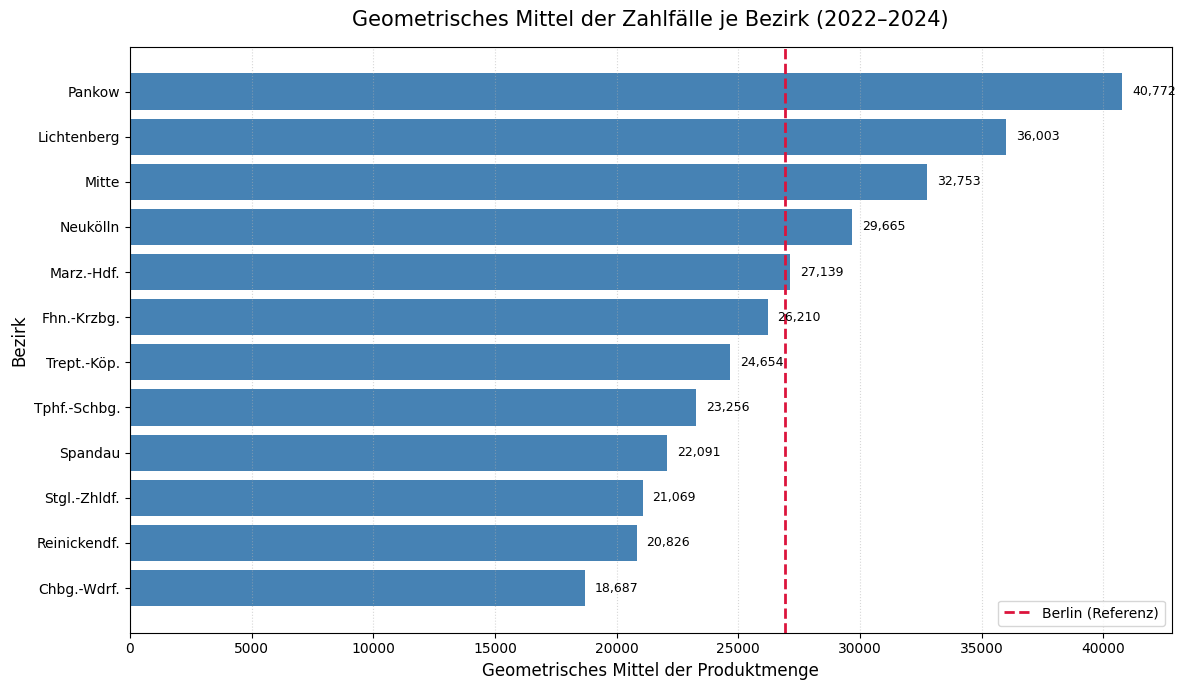

In [18]:
plot_geo_mean_bezirk(gm_fix_bezirk, gm_fix_berlin)

### 4.6.2 Geometrisches Mittel im Rolling-Fenster (3 Jahre) zwischen 2020–2024

Linienplot pro Bezirk inklusive Referenzlinie für Gesamtberlin. Rolling-Fenster über drei Jahre bedeutet:</br>

- Erstes Fenster: geometrische Mittel berechnet zwischen 2020-2022.</br>
- Zweites Fenster: geometrische Mittel berechnet zwischen 2021-2023.</br>
- Drittes Fenster: geometrische Mittel berechnet zwischen 2022-2024.</br>

In [19]:
## Rolling-Geometrisches-Mittel berechnen

# Sortierung zwingend notwendig
df_roll = df_80992.sort_values(["Bezirk", "year"]).copy()

def rolling_geo_mean(series, window=3):
    return series.rolling(window).apply(
        lambda x: np.exp(np.mean(np.log(x))), raw=False
    )

df_roll["geo_mean_rolling_3y"] = (
    df_roll
    .groupby("Bezirk")["Produkt_menge"]
    .transform(rolling_geo_mean)
)

# Nur vollständige Fenster behalten
df_roll = df_roll.dropna(subset=["geo_mean_rolling_3y"])

# Berlin als Durchschnitt der Bezirke
berlin_roll = (
    df_roll
    .groupby("year")["geo_mean_rolling_3y"]
    .mean()
)

In [20]:

def plot_rolling_geo_mean(df_roll, berlin_roll, title="Rolling 3-Jahres-Geometrisches Mittel der Zahlfälle (2020–2024)"):
    """
    Visualisiert das Rolling-Geometrische-Mittel je Bezirk und hebt Berlin hervor.
    """
    plt.figure(figsize=(14, 7))
    colors = plt.colormaps.get_cmap('tab20').resampled(len(df_roll["Bezirk"].unique()))
    for i, (bezirk, grp) in enumerate(df_roll.groupby("Bezirk")):
        plt.plot(
            grp["year"],
            grp["geo_mean_rolling_3y"],
            color=colors(i),
            alpha=0.5,
            linewidth=2,
            label=bezirk if i < 1 else None  # Nur einen Bezirk im Legendenbeispiel
        )

    # Berlin-Referenz
    plt.plot(
        berlin_roll.index,
        berlin_roll.values,
        linestyle="--",
        linewidth=3,
        color="crimson",
        label="Berlin (Referenz)"
    )

    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Jahr (Ende des 3-Jahres-Fensters)", fontsize=13)
    plt.ylabel("Geometrisches Mittel der Produktmenge", fontsize=13)
    plt.grid(axis="y", linestyle=":", alpha=0.5)
    plt.legend(loc="upper left", frameon=True, fontsize=11)
    plt.tight_layout()
    plt.show()

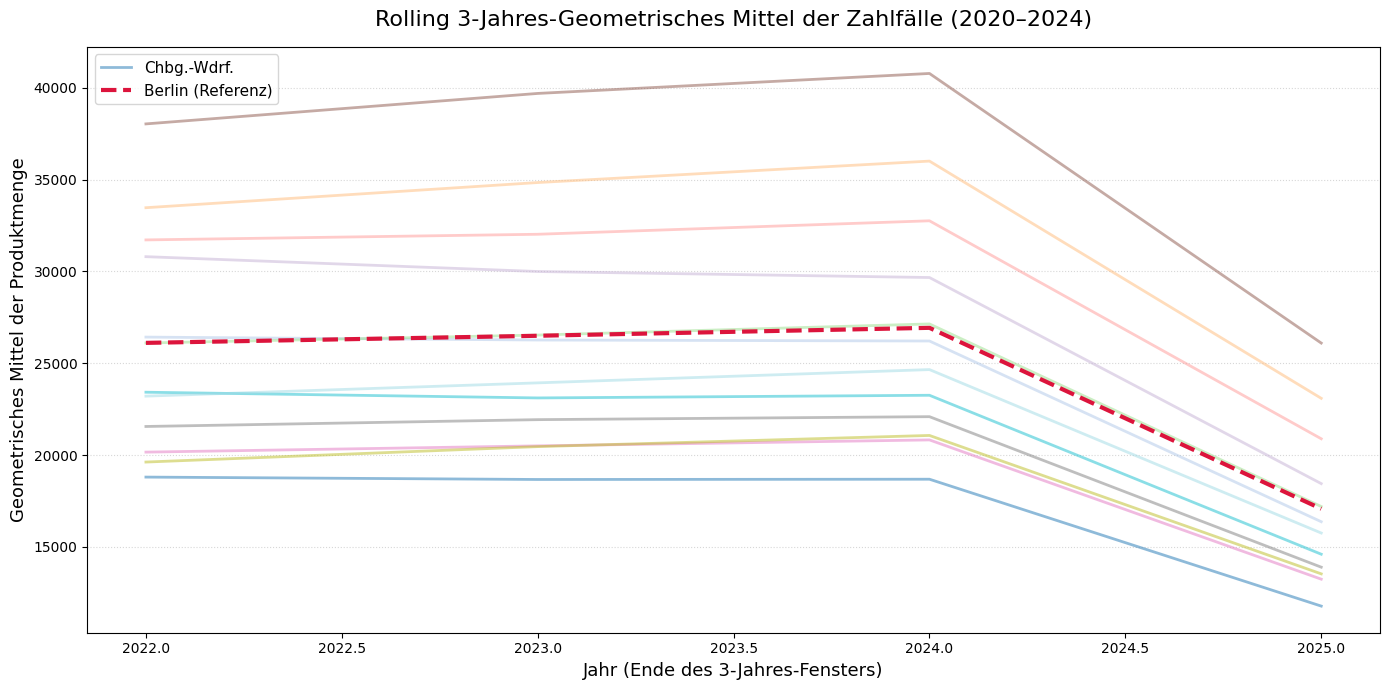

In [21]:
plot_rolling_geo_mean(df_roll, berlin_roll)

### 4.6.3 Grafische Abweichung je Bezirk zu Berlin

1. Heatmap der Prozentabweichung
2. Divergenzplot als Zeitreihe der Abweichung (Berlin = 0 Linie)

In [22]:
# Abweichung zu Berlin in %
df_roll = df_roll.copy()
df_roll["abweichung_zu_berlin_pct"] = (df_roll["geo_mean_rolling_3y"] / df_roll["year"].map(berlin_roll) - 1.0) * 100

# Pivot für Heatmap
hm = df_roll.pivot_table(
    index="Bezirk",
    columns="year",
    values="abweichung_zu_berlin_pct",
    aggfunc="mean"
)

# Optional: Sortierung nach Mittelwert (damit "stärkste Abweichler" oben/unten)
hm = hm.loc[hm.mean(axis=1).sort_values(ascending=True).index]

In [23]:
def plot_abweichung_heatmap(
    hm,
    title="Heatmap: Prozentabweichung zum Berlin-Referenzwert (Rolling 3 Jahre)",
    cmap="RdYlBu"
):
    """
    Visualisiert eine Heatmap der Prozentabweichung zum Berlin-Referenzwert (Rolling 3 Jahre)
    mit professionellem, augenfreundlichem Farbschema.
    """
    plt.figure(figsize=(12, max(6, 0.35 * len(hm.index))))
    # RdYlBu ist augenfreundlich, farbenblind-sicher und professionell
    im = plt.imshow(
        hm.values,
        aspect="auto",
        cmap=cmap,
        vmin=-np.nanmax(abs(hm.values)),
        vmax=np.nanmax(abs(hm.values))
    )

    plt.title(title, fontsize=16, pad=15)
    plt.xlabel("Jahr (Ende des 3-Jahres-Fensters)", fontsize=13)
    plt.ylabel("Bezirk", fontsize=13)

    plt.xticks(ticks=np.arange(len(hm.columns)), labels=hm.columns)
    plt.yticks(ticks=np.arange(len(hm.index)), labels=hm.index)

    cbar = plt.colorbar(im)
    cbar.set_label("Abweichung zu Berlin (%)")

    plt.tight_layout()
    plt.show()

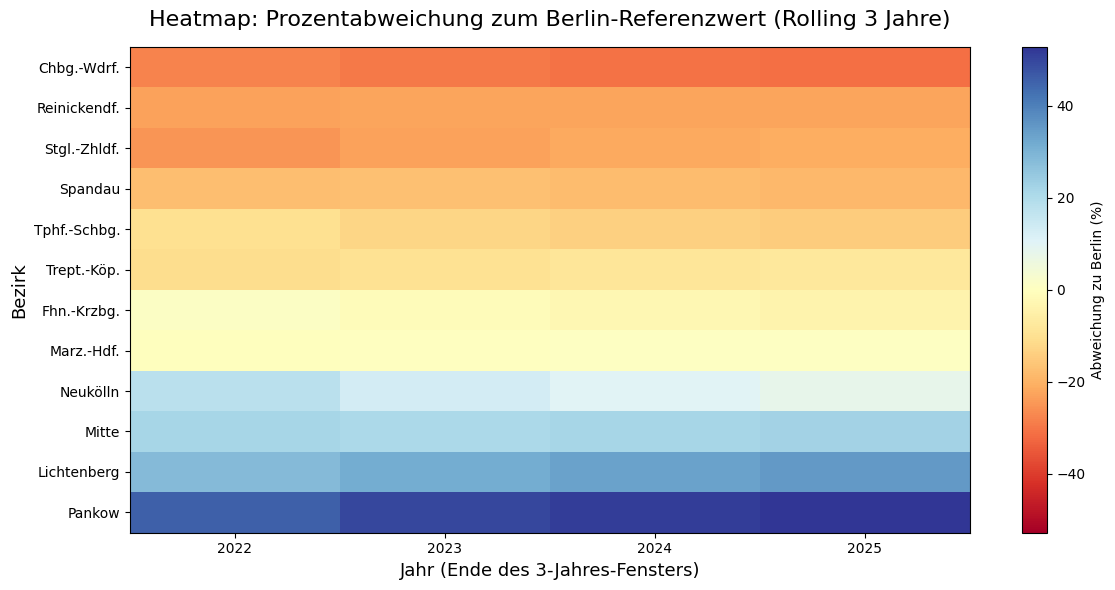

In [24]:
plot_abweichung_heatmap(hm)

Divergenzplot – Top/Bottom-5-Bezirke vs. Berlin (0-Linie) (Variante B)

Ein Divergenzplot zeigt:
Die Abweichung eines Bezirks vom Referenzwert über die Zeit

In [25]:
# Auswahl: Bezirke mit größter absoluter Abweichung im letzten Jahr
last_year = df_roll["year"].max()

last_snapshot = (
    df_roll[df_roll["year"] == last_year]
    .dropna(subset=["abweichung_zu_berlin_pct"])
    .set_index("Bezirk")["abweichung_zu_berlin_pct"]
)

top5 = last_snapshot.sort_values(ascending=False).head(5).index.tolist()
bottom5 = last_snapshot.sort_values(ascending=True).head(5).index.tolist()
focus = list(dict.fromkeys(top5 + bottom5))  # Unique, Reihenfolge behalten

df_focus = df_roll[df_roll["Bezirk"].isin(focus)].copy()

In [26]:
def plot_divergenzplot(df_focus, last_year, title=None):
    """
    Divergenzplot: Zeigt die Abweichung ausgewählter Bezirke zum Berlin-Referenzwert über die Zeit.
    Farben und Stil sind professionell und augenfreundlich.
    """
    plt.figure(figsize=(12, 6))
    # Farbpalette: Tableau, angenehm und farbenblindfreundlich
    colors = plt.colormaps.get_cmap("tab10").colors
    for i, (bezirk, grp) in enumerate(df_focus.groupby("Bezirk")):
        plt.plot(
            grp["year"], grp["abweichung_zu_berlin_pct"],
            linewidth=2,
            label=bezirk,
            color=colors[i % len(colors)]
        )

    plt.axhline(0, linestyle="--", linewidth=2, color="grey", alpha=0.7, label="Berlin-Referenz (0%)")

    if not title:
        title = f"Divergenzplot: Top/Bottom 5 Bezirke vs Berlin (Rolling 3J, Endjahr {last_year})"
    plt.title(title, fontsize=15, pad=12)
    plt.xlabel("Jahr (Ende des 3-Jahres-Fensters)", fontsize=12)
    plt.ylabel("Abweichung zu Berlin (%)", fontsize=12)
    plt.legend(ncol=2, frameon=True, fontsize=10)
    plt.grid(True, alpha=0.2, linestyle=":")
    plt.tight_layout()
    plt.show()

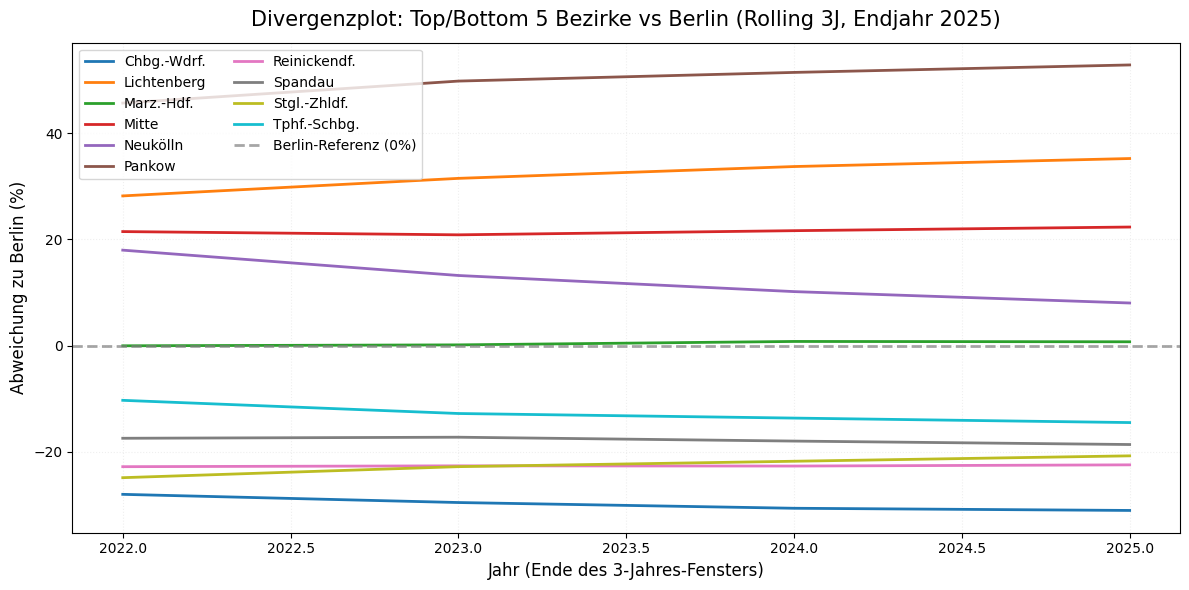

In [27]:
plot_divergenzplot(df_focus, last_year)

### 4.6.4 Ergebnisse der Visualisierungen
- ddd
- ddd



# 5 Follow-up

- Zusätzliche Aufgabe: Prognose für das restliche Jahr 2025 bzw. kommende Jahre mithilfe von Machine Learning Algorithmen, Beispiele: ETS/Exponential Smoothing oder SARIMAX